<a href="https://colab.research.google.com/github/KyraZzz/partii-work/blob/main/bioinfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global alignment

In [ ]:
def print_global_align(seq1,seq2,op):
  m = len(seq1); i = m
  n = len(seq2); j = n
  align1 = ""
  align2 = ""

  while i > 0 and j > 0:
    if op[i][j] == 1:
      align1 += seq1[i-1]
      align2 += seq2[j-1]
      i -= 1; j -= 1
    elif op[i][j] == 2:
      align1 += seq1[i-1]
      align2 += "-"
      i -= 1 
    elif op[i][j] == 3:
      align1 += "-"
      align2 += seq2[j-1]
      j -= 1
  
  while i > 0:
    align1 += seq1[i-1]
    align2 += "-"
    i -= 1
  while j > 0:
    align1 += "-"
    align2 += seq2[j-1]
    j -= 1
  
  print(align1[::-1] + "\n" + align2[::-1])

def needleman_wunsch(seq1,seq2,match_award=1,mismatch_pen=-1,indel_pen=-1):
  m = len(seq1)
  n = len(seq2)
  dp = [[0 for _ in range(n+1)] for _ in range(m+1)]
  op = [[0 for _ in range(n+1)] for _ in range(m+1)] # 1: diagonal, 2: right(insert), 3: down(delete)

  # fill in score matrix
  for i in range(1,m+1):
    dp[i][0] = indel_pen * i
  for j in range(1,n+1):
    dp[0][j] = indel_pen * j
  
  for i in range(1,m+1):
    for j in range(1,n+1):
      insert = dp[i-1][j] + indel_pen
      delete = dp[i][j-1] + indel_pen
      match_mismatch = dp[i-1][j-1] + match_award if seq1[i-1] == seq2[j-1] else dp[i-1][j-1] + mismatch_pen
      dp[i][j] = max(insert, delete, match_mismatch)
      if insert == dp[i][j]:
        op[i][j] = 2
      elif delete == dp[i][j]:
        op[i][j] = 3
      else:
        op[i][j] = 1
    
  # print optimal global alignment
  print_global_align(seq1,seq2,op)
  return dp, op

In [ ]:
seq1 = "CGTGAA"
seq2 = "GACTTAC"
needleman_wunsch(seq1,seq2,match_award=5,mismatch_pen=-3,indel_pen=-4)

--CGTGAA
GACTT-AC


([[0, -4, -8, -12, -16, -20, -24, -28],
  [-4, -3, -7, -3, -7, -11, -15, -19],
  [-8, 1, -3, -7, -6, -10, -14, -18],
  [-12, -3, -2, -6, -2, -1, -5, -9],
  [-16, -7, -6, -5, -6, -5, -4, -8],
  [-20, -11, -2, -6, -8, -9, 0, -4],
  [-24, -15, -6, -5, -9, -11, -4, -3]],
 [[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 3, 1, 3, 3, 3, 3],
  [0, 1, 3, 2, 1, 3, 3, 3],
  [0, 2, 1, 3, 1, 1, 3, 3],
  [0, 2, 2, 1, 2, 2, 1, 3],
  [0, 2, 1, 3, 1, 2, 1, 3],
  [0, 2, 2, 1, 3, 1, 2, 1]])

# Local alignment

In [ ]:
import numpy as np
def print_local_align(seq1,seq2,dp,op):
  arr = np.array(dp)
  i,j = np.unravel_index(arr.argmax(),arr.shape)
  align1 = ""
  align2 = ""

  while i > 0 and j > 0 and dp[i][j] != 0:
    if op[i][j] == 1:
      align1 += seq1[i-1]
      align2 += seq2[j-1]
      i -= 1; j -= 1
    elif op[i][j] == 2:
      align1 += seq1[i-1]
      align2 += "-"
      i -= 1 
    elif op[i][j] == 3:
      align1 += "-"
      align2 += seq2[j-1]
      j -= 1
  
  print(align1[::-1] + "\n" + align2[::-1])

def smitch_waterman(seq1,seq2,match_award=1,mismatch_pen=-1,indel_pen=-1):
  m = len(seq1)
  n = len(seq2)
  dp = [[0 for _ in range(n+1)] for _ in range(m+1)]
  op = [[0 for _ in range(n+1)] for _ in range(m+1)] # 1: diagonal, 2: right(insert), 3: down(delete), 4: reset(0)

  # fill in score matrix
  for i in range(1,m+1):
    for j in range(1,n+1):
      insert = dp[i-1][j] + indel_pen
      delete = dp[i][j-1] + indel_pen
      match_mismatch = dp[i-1][j-1] + match_award if seq1[i-1] == seq2[j-1] else dp[i-1][j-1] + mismatch_pen
      dp[i][j] = max(0,insert, delete, match_mismatch)
      if insert == dp[i][j]:
        op[i][j] = 2
      elif delete == dp[i][j]:
        op[i][j] = 3
      elif match_mismatch == dp[i][j]:
        op[i][j] = 1
      else:
        op[i][j] = 4
  
  # print optimal local alignment
  print_local_align(seq1,seq2,dp,op)
  return dp, op

In [ ]:
seq1 = "GCCGCCGTCGTTTTCAGCAGTTATGTTCAGAT"
seq2 = "GCCCAGTCTATGTCAGGGGCACGAGCATGCACA"
dp, op = smitch_waterman(seq1,seq2)

CAGT-TATGTTCAG
CAGTCTATGT-CAG


# Alignment with affine gap penalities

In [ ]:
def print_global_align_affine_gap_penalty(v,w,F,op):
  m = len(v); i = m
  n = len(w); j = n

  alignv = ""
  alignw = ""

  start_level_choice = [F[0][i][j], F[1][i][j], F[2][i][j]]
  curr_level = start_level_choice.index(max(start_level_choice))

  while i > 0 and j > 0:
    next_level = op[curr_level][i][j] 
    if curr_level == 0:
      alignv += v[i-1]
      alignw += "-"
      i -= 1
    elif curr_level == 2:
      alignv += "-"
      alignw += w[j-1]
      j -= 1
    elif curr_level == 1 and next_level == 1:
        alignv += v[i-1]
        alignw += w[j-1]
        i -= 1; j -= 1
    curr_level = next_level
  
  while i > 0:
    alignv += v[i-1]
    alignw += "-"
    i -= 1
  while j > 0:
    alignv += "-"
    alignw += w[j-1]
    j -= 1
  
  print(alignv[::-1] + "\n" + alignw[::-1])

def global_alignment_affine_gap_penalty(v,w,scoring_matrix, sigma=2, epsilon=1):
  m = len(v)
  n = len(w)
  F = [[[0 for _ in range(n+1)] for _ in range(m+1)] for _ in range(3)]
  op = [[[k for _ in range(n+1)] for _ in range(m+1)] for k in range(3)]

  # initialise 3 level edges
  for i in range(1, m+1):
    F[0][i][0] = -sigma - epsilon * (i-1)
    F[1][i][0] = -sigma - epsilon * (i-1)
    F[2][i][0] = -sigma - epsilon * (i-1)
  for j in range(1, n+1):
    F[0][0][j] = -sigma - epsilon * (j-1)
    F[1][0][j] = -sigma - epsilon * (j-1)
    F[2][0][j] = -sigma - epsilon * (j-1)

  # filling F and op for 3 levels
  for i in range(1,m+1):
    for j in range(1,n+1):
      lower_scores = [F[0][i-1][j] - epsilon, F[1][i-1][j] - sigma]
      F[0][i][j] = max(lower_scores)
      op[0][i][j] = lower_scores.index(F[0][i][j])
      upper_scores = [F[1][i][j-1] - sigma,F[2][i][j-1] - epsilon]
      F[2][i][j] = max(upper_scores)
      op[2][i][j] = upper_scores.index(F[2][i][j]) + 1
      middle_scores = [F[0][i][j],F[1][i-1][j-1]+scoring_matrix[i][j],F[2][i][j]]
      F[1][i][j] = max(middle_scores)
      op[1][i][j] = middle_scores.index(F[1][i][j])
    
  # print optimal global alignment
  print_global_align_affine_gap_penalty(v,w,F,op)
  return F, op

In [ ]:
seq1 = "GATCCAG"
seq2 = "GACAG"
scoring_matrix = [[-1 for _ in range(len(seq2)+1)] for _ in range(len(seq1)+1)]
for i in range(1,len(seq1)+1):
  for j in range(1,len(seq2)+1):
    if seq1[i-1] == seq2[j-1]:
      scoring_matrix[i][j] = 1
    else:
      scoring_matrix[i][j] = -1
F, op = global_alignment_affine_gap_penalty(seq1,seq2,scoring_matrix)

GATCCAG
GA--CAG


# Compute alignment score with linear memory

In [ ]:
def global_alignscore_linear_space(seq1,seq2,match_award=1,mismatch_pen=-1,indel_pen=-1):
  m = len(seq1)
  n = len(seq2)
  dp_prev = [0 for _ in range(n+1)]
  dp_curr = [0 for _ in range(n+1)]
  # fill in score matrix
  for i in range(1,n+1):
    dp_prev[i] = indel_pen * i
  
  for i in range(1,m+1):
    dp_curr[0] = indel_pen * i
    for j in range(1,n+1):
      insert = dp_prev[j] + indel_pen
      delete = dp_curr[j-1] + indel_pen
      match_mismatch = dp_prev[j-1] + match_award if seq1[i-1] == seq2[j-1] else dp_prev[j-1] + mismatch_pen
      dp_curr[j] = max(insert, delete, match_mismatch)
    dp_prev = [i for i in dp_curr]
    
  return dp_curr

In [ ]:
seq1 = "CGTGAA"
seq2 = "GACTTAC"
global_alignscore_linear_space(seq1, seq2, match_award=5,mismatch_pen=-3,indel_pen=-4)

[-24, -15, -6, -5, -9, -11, -4, -3]

# Middle edge problem

In [ ]:
midEdgeMap = {0: ➡️, 1: ⬇️, 2: ↘️}
scoring_matrix
def middleNode():
  
def middleEdge(top, bottom, left, right):
  """
  Returns the middle edge in the alignment graph
  """
  # prefix(i)
  prefix = middleNode()
def linearSpaceAlignment(top, bottom, left, right):
  if left == right: return [alignment formed by bottom-top vertical edges]
  if top == bottom: return [alignment formed by right-left horicontal edges]
  middle = int((left + right) / 2)
  midNode = middleNode(top, bottom, left, right)
  midEdge = middleEdge(top, bottom, left, right)
  linearSpaceAlignment(top, midNode, left, middle)
  print(midEdgeMap[midEdge])
  if midEdge == 0 or midEdge == 2:
    middle += 1
  elif midEdge == 1 or midEdge == 2:
    midNode += 1
  linearSpaceAlignment(midNode, bottom, middle, right)

# UPGMA

In [ ]:
import numpy as np

In [ ]:
class Node:
  def __init__(self, val, lc = None, rc = None, dist_map = None):
    self.val = val
    self.lc = lc
    self.rc = rc
    self.distance = dist_map
  
  def add_distances(self, dist_map):
    self.distance = dist_map

In [ ]:
def UPGMA(clusters):
  root = None
  while len(clusters) > 1:
    print(f"current clusters: {[k.val for k in clusters]}")
    nodemap = {k.val:k for k in clusters}
    minDist = 1e32
    minPair1 = None
    minPair2 = None
    for i in clusters:
      if min(i.distance.values()) < minDist:
        minPair1 = i
        minPair2 = min(i.distance, key=i.distance.get)
        minDist = min(i.distance.values())
    print(f"merge two clusters: {minPair1.val} and {minPair2.val}")
    clusters.remove(nodemap[minPair1.val])
    clusters.remove(nodemap[minPair2.val])
    intnodes = set(minPair1.distance.keys()).intersection(set(minPair2.distance.keys()))
    root = Node(f"({minPair1.val},{minPair2.val})", minPair1, minPair2)
    newmap = {}
    for n in intnodes:
      avgdist = (minPair1.distance[n] + minPair2.distance[n]) / 2
      newmap[n] = avgdist
      del n.distance[minPair1]
      del n.distance[minPair2]
      n.distance[root] = avgdist
    root.add_distances(newmap)
    clusters.append(root)
      
  return root

In [ ]:
A = Node('A')
B = Node('B')
C = Node('C')
D = Node('D')
A.add_distances({B: 2, C: 4, D: 6})
B.add_distances({C: 2, C: 4, D: 6})
C.add_distances({A: 4, B: 4, D: 6})
D.add_distances({A: 6, B: 6, C: 6})
clusters = [A, B, C, D]
root = UPGMA(clusters)
print(root.val)

current clusters: ['A', 'B', 'C', 'D']
merge two clusters: A and B
current clusters: ['C', 'D', '(A,B)']
merge two clusters: C and (A,B)
current clusters: ['D', '(C,(A,B))']
merge two clusters: D and (C,(A,B))
(D,(C,(A,B)))


# Lloyd's algorithm

In [1]:
import numpy as np
import random

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def lloyd_clustering(points, k = 4):
  centers = points[np.random.randint(0, len(points), size=k)]
  assign = None
  while True:
    assign = {i:[] for i in range(k)}
    # centres to clusters
    for x,y in points:
      mindis = 1e32
      cluster = 0
      for idx, val in enumerate(centers):
        cx, cy = val[0], val[1]
        diff = np.sqrt(np.power(x - cx, 2) + np.power(y - cy, 2))
        if mindis > diff:
          mindis = diff
          cluster = idx
      assign[cluster].append([x,y])
    # clusters to centers
    new_centers = centers
    for k,v in assign.items():
      v = np.array(v)
      new_centers[k] = [v[:, 0].mean(), v[:, 1].mean()]
    if (new_centers == centers).all():
      break
  return centers, assign

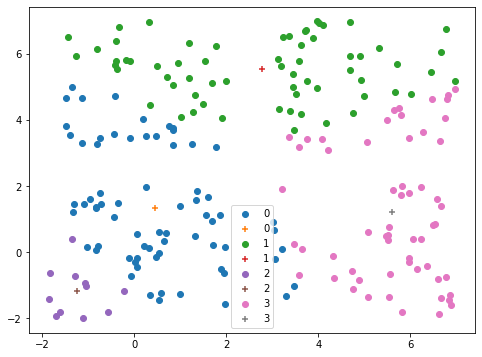

In [ ]:
n = 50
points = []
centers = [(0,0), (0,5), (5,0), (5,5)]
for c in centers:
  points += [(random.uniform(-2,2) + c[0], random.uniform(-2,2) + c[1]) for _ in range(max(0, n + random.randint(-5,5)))]
points = np.array(points)
k = 4
centers, assign = lloyd_clustering(points, k)

fig,ax = plt.subplots(figsize=(8,6))
for k, v in assign.items():
  v = np.array(v)
  ax.scatter(v[:,0], v[:,1], label=k)
  ax.scatter(centers[k,0], centers[k, 1], marker='+', label=k)
plt.legend()
plt.show()

# BWT

# HMM

In [144]:
class HMM:
  def __init__(self, alphabet, hidden_states, emit_string, init_prob, transition, emission):
    self.alphabet = alphabet
    self.hidden_states = hidden_states
    self.hidden_path = None
    self.emit_string = emit_string
    self.init_prob = init_prob
    self.transition = transition
    self.emission = emission

  def evaluate(self, emit_string = None):
    if emit_string is not None:
      self.emit_string = emit_string
    forward_prob = [p * self.emission[i][self.emit_string[0]] for i, p in enumerate(self.init_prob)]
    for t, x in enumerate(self.emit_string[1:]):
      new_prob = [0 for _ in self.hidden_states]
      for j in self.hidden_states:
        prob = 0
        for i in self.hidden_states:
          prob += forward_prob[i] * self.transition[i][j]
        prob *= self.emission[j][x]
        new_prob[j] = prob
      print(f"forward_prob: {forward_prob}")
      forward_prob = new_prob
    return np.array(forward_prob).sum()
  
  def decode(self, emit_string = None):
    if emit_string is not None:
      self.emit_string = emit_string
    V = [[0] * len(self.emit_string) for _ in self.hidden_states]
    psi = [[-1] * len(self.emit_string) for _ in self.hidden_states]
    for i in self.hidden_states:
      V[i][0] = self.init_prob[i] * self.emission[i][self.emit_string[0]]

    # fill stage
    for t, x in enumerate(self.emit_string):
      if t == 0: continue
      for j in self.hidden_states:
        maxprob = 0
        opt_psi = -1
        for i in self.hidden_states:
          prob = V[i][t-1] * self.transition[i][j]
          if prob > maxprob:
            maxprob = prob
            opt_psi = i
        V[j][t] = maxprob * self.emission[j][x]
        psi[j][t] = opt_psi

    # backtrack stage
    opt_s = np.argmax(np.array(V[:][-1]))
    hidden_path = [opt_s]
    for t in range(len(self.emit_string)-1, 1, -1):
      opt_s = psi[opt_s][t]
      hidden_path.append(opt_s)
    return hidden_path[::-1], V

In [145]:
"""
alphabet: [A, T, C, G], simplify as [0, 1, 2, 3]
hidden states: [x, y, z], simplify as [0, 1, 2]
"""
alphabet = [0, 1, 2, 3]
alphabet_map = {"A":0, "T":1, "C":2, "G":3}
hidden_states = [0, 1, 2]
hidden_states_map = {0:"x", 1:"y", 2:"z"}
ori_string = "CCGAAGTG"
emit_string = [alphabet_map[c] for c in ori_string]
init_prob = [0.3, 0.3, 0.4]
transition = [
    [0.2, 0.4, 0.4],
    [0.1, 0.6, 0.3],
    [0.8, 0.1, 0.1]
]
emission = [
    [0.7, 0.1, 0.1, 0.1],
    [0.3, 0.2, 0.4, 0.1],
    [0.4, 0.2, 0.2, 0.2]
]
print(f"emit_string: {emit_string}")

emit_string: [2, 2, 3, 0, 0, 3, 1, 3]


In [146]:
m = HMM(alphabet, hidden_states, emit_string, init_prob, transition, emission)

In [147]:
m.evaluate()

forward_prob: [0.03, 0.12, 0.08000000000000002]
forward_prob: [0.008200000000000002, 0.0368, 0.011200000000000002]
forward_prob: [0.0014280000000000002, 0.002648, 0.0030880000000000005]
forward_prob: [0.00211456, 0.00074064, 0.0006697600000000001]
forward_prob: [0.0007229488, 0.00040715520000000004, 0.00045399680000000013]
forward_prob: [5.4850272000000016e-05, 5.7887232000000005e-05, 9.134515200000002e-05]
forward_prob: [8.983489920000002e-06, 1.3161392640000003e-05, 9.688158720000004e-06]


4.0343670912000014e-06

In [148]:
res, V = m.decode()
[hidden_states_map[i] for i in res]

['y', 'z', 'x', 'z', 'x', 'z', 'x']

In [150]:
V[0][3]

0.0009676800000000001